# 背景概述

$\quad$你是脸盲吗😱? 不管是不是, 都欢迎完成本次上机作业! 我们将构建一个基于支持向量机的人脸识别器, 判定某张人脸图片归属于数据库内的哪个人. 我们将使用[LFW(Labeled Faces in the Wild)数据集](https://vis-www.cs.umass.edu/lfw/), 其中含有若干张人脸图片(RGB三通道彩图)及其对应的人名.

# 数据的读取与清洗

$\quad$我们可以利用[`sklearn.datasets`](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.datasets)模块的函数[`fetch_lfw_people`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_lfw_people.html#sklearn.datasets.fetch_lfw_people)自动在特定的条件要求下进行人脸图片抓取.

- **任务1**: 完成函数`process_lfw_data`的编写, 实现数据集的预处理、训练-测试分拆与描述性参数的整理. 输入:
  - `lfw_data`, 经过`fetch_lfw_people`函数下载(或加载好)的数据集. 这是一个类似于字典的数据结构, 类属性保存了关于这个数据集的若干描述性信息, 例如`images`、`target`、`target_names`等.
  - `test_size`, 测试集大小. 默认值为0.3, 即训练集 : 测试集 = 7 : 3. 进行拆分时, 要求对原数据集做一次随机打乱(`shuffle=True`).
  - `random_state`, 用于传入`sklearn`中涉及随机性的函数(例如[`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn-model-selection-train-test-split)), 保证可复现性. 默认值为42.
- 返回一个五元元组, 前四个元素分别是拆分好的`X_train`、`X_test`、`y_true_train`、`y_true_test`, 最后一个元素是一个元组, 内容按顺序包括:
  - 人脸图片高度`H`;
  - 人脸图片宽度`W`;
  - 数据集中涵盖了多少人`n_classes`;
  - 数据集中涵盖的那些人的名字`target_names`, 要求返回的是一个列表.
- 由于`X`的取值区间是`[0, 255)`, 因此要求对`X`进行数据重标度: 各个值除以255.

### 提示
- `fetch_lfw_people`函数默认将RGB三个色彩通道加工处理成单通道的灰度图, 因此不需要担心多个色彩通道的问题.
- 由于数据集被施加了若干限制条件(详见下一个代码块), 因此你在编写函数时, 需要访问`lfw_data`对应的类属性, 而不能直接根据官方文档的数字直接抄写.

In [1]:
from sklearn.datasets import fetch_lfw_people
lfw_data = fetch_lfw_people(min_faces_per_person=100, resize=0.4)

In [2]:
lfw_data.data

array([[ 85.666664,  81.666664,  53.      , ..., 110.666664, 117.333336,
        181.66667 ],
       [ 48.666668,  56.333332,  87.333336, ..., 234.33333 , 231.66667 ,
        223.      ],
       [ 37.333332,  39.666668,  49.666668, ..., 103.333336,  81.333336,
         59.666668],
       ...,
       [226.      , 220.      , 202.33333 , ..., 148.66667 , 147.66667 ,
        160.66667 ],
       [102.333336, 126.      , 141.66667 , ..., 212.33333 , 217.66667 ,
        162.      ],
       [ 48.333332,  91.333336, 128.33333 , ...,  17.666666,  30.333334,
         28.666666]], dtype=float32)

In [3]:
from typing import List, Tuple
import numpy as np
from sklearn.model_selection import train_test_split

def process_lfw_data(
    lfw_data, test_size: int=0.3, random_state: int=42
) -> Tuple[np.array, np.array, np.array, np.array, Tuple[int, int, int, List[str]]]:
    ### BEGIN YOUR SOLUTION ###
    X_train, X_test, y_true_train, y_true_test = train_test_split(lfw_data.data,lfw_data.target, test_size=test_size, random_state=random_state, shuffle=True)
    n_samples, H, W = lfw_data.images.shape
    n_classes = lfw_data.target_names.shape[0]

    X_train = X_train/255
    X_test = X_test/255
    target_name = lfw_data.target_names.tolist()
    return (X_train, X_test, y_true_train, y_true_test, (H, W, n_classes,target_name))
    ### END YOUR SOLUTION ###

$\quad$完成任务1后, 请**务必**运行下面的代码块做检查. 初次运行可能需要花费几分钟, 因为需要下载数据集. 不过, 运行完一次后再反复运行, 程序就将非常快地从内存中读取数据了.
- 我们对`fetch_lfw_people`所筛选的人脸数据做出如下要求: 所提取的那些人必须至少录入了100张人脸图片, 且这些图片都将以0.4的比例被压缩.

In [4]:
from sklearn.datasets import fetch_lfw_people
lfw_data = fetch_lfw_people(min_faces_per_person=100, resize=0.4)
X_train, X_test, y_true_train, y_true_test, (H, W, n_classes, target_names) = process_lfw_data(lfw_data)
H, W, n_classes, target_names

(50,
 37,
 5,
 ['Colin Powell',
  'Donald Rumsfeld',
  'George W Bush',
  'Gerhard Schroeder',
  'Tony Blair'])

# SVM模型超参数的探索

$\quad$我们下面先定性讨论超参数`C`与`gamma`对模型性能的影响, 再用网格搜索进行超参数优化. 为此, 请先运行下述代码块导入必要的库函数. 其中, [`cross_val_score`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html#sklearn-model-selection-cross-val-score)函数用于交叉验证的平均得分的计算, 在不手动传入`scoring`参数的情况下, 对分类问题默认采用(验证集上的)accuracy作为评估指标.

In [5]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

## 超参数试验: 间隔软度与核函数系数

- **任务2**: 分别讨论超参数对模型性能的影响.
  - **任务2.1**: 其他条件不变, 取`C`分别为0.1、1、10;
  - **任务2.2**: 其他条件不变, 取`gamma`分别为0.001、0.01、0.1.

$\quad$运行下述代码块, 观察结果, 在对应答题区解释你关于`C`值的发现.
- 提示: `C`值起什么作用? 当它变化时, 欠拟合/过拟合的情况怎样?

In [6]:
X_train.shape

(798, 1850)

In [7]:
scores_vs_C = []
for C in (0.1, 1, 10):
    clf = SVC(C=C)
    scores_vs_C.append(cross_val_score(clf, X_train, y_true_train, n_jobs=-1).mean())
scores_vs_C

### 任务2.1答题区(另起一行时请记得加注释符号#) ###
### BEGIN YOUR SOLUTION ###
# C的值越高，训练数据的拟合越好，即正则化的强度越低。太高说明正则化对参数的惩罚较小，容易过拟合；太低则施加了过度的参数惩罚，导致训练出来的参数都很低，欠拟合会比较严重
### END YOUR SOLUTION ###

[0.46491352201257863, 0.7431682389937107, 0.8359119496855346]

$\quad$运行下述代码块, 观察结果, 在对应答题区解释你关于`gamma`值的发现.
- 提示: `gamma`值描述了(RBF)核函数的什么性质? 当它变化时, 欠拟合/过拟合的情况怎样?

In [8]:
scores_vs_gamma = []
for gamma in (0.001, 0.01, 0.1):
    clf = SVC(gamma=gamma)
    scores_vs_gamma.append(cross_val_score(clf, X_train, y_true_train, n_jobs=-1).mean())
scores_vs_gamma

### 任务2.2答题区(另起一行时请记得加注释符号#) ###
### BEGIN YOUR SOLUTION ###
# gamma值描述了RBF核函数的性质，决定单个训练数据的影响程度。gamma值越大，要求每个类种数据越接近，越容易过拟合，反之gamma值过小则容易欠拟合
### END YOUR SOLUTION ###

[0.46616352201257855, 0.7143317610062894, 0.5125157232704403]

## 超参数的组合优化

$\quad$现在, 我们使用[`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html#sklearn.model_selection.GridSearchCV)工具完成超参数优化.

- **任务3**: 对超参数`C`与`gamma`进行基于5-折交叉验证的网格搜索(这是`GridSearchCV`的默认设置), 并对模型性能进行可视化.
  - **任务3.1**: 完成函数`get_cv_data`的编写, 输入:
    - 两个超参数各自的搜索空间`C_space`和`gamma_space`;
    - 用于交叉验证的训练集`X_train`和`y_true_train`.
  - 返回一个二元元组, 内容分别为:
    - 用于三维作图的一个三元组, 分别为`C`、`gamma`和`score`(交叉验证平均得分)组成的二维数组(详见提示).
    - 最优超参数配置, 以字典形式返回.
  - **任务3.2**: 运行后续的两个代码块, 观察(三维)模型性能示意图, 分析`C`与`gamma`之间的关系.

### 提示
- 任务3.2中所做的图是以函数[`plot_surface`](https://matplotlib.org/stable/api/_as_gen/mpl_toolkits.mplot3d.axes3d.Axes3D.plot_surface.html#mpl_toolkits.mplot3d.axes3d.Axes3D.plot_surface)作出的三维空间内的曲面图, `x`轴、`y`轴分别为超参数`C`和`gamma`的取值, 而`z`轴则是交叉验证的平均性能. 这三根轴都必须是同样形状的二维数组, 行数等于`x`轴数据量、列数等于`y`轴数据量. 由于`GridSearchCV`函数对交叉验证结果的保存形式是(一维的)列表, 所以, 你也许需要: (1) 逐项遍历`cv_results_`中的超参数配置和对应得分, 先得到三个一维列表(三根轴上的数据); (2) 从这些一维列表出发, 构造三个对应的`np.array`数组, 并将它们按作图要求`reshape`为一个二维数组.
- 机器配置为`c2_m4_cpu`, 是允许2核并行的. 所以, 建议设置`GridSearchCV`的参数`n_jobs`为2(或-1, 代表所有可用的核).

In [9]:
from typing import Dict
from sklearn.model_selection import GridSearchCV

def get_cv_data(
    C_space: np.array, gamma_space: np.array, X_train: np.array, y_true_train: np.array
) -> Tuple[Tuple[np.array, np.array, np.array], Dict]:
    ### BEGIN YOUR SOLUTION ###
    C_params = [i for i in C_space]
    gamma_params = [i for i in gamma_space]
    param_grid = {"C":C_params, "gamma":gamma_params}
    clf = SVC()
    cv = GridSearchCV(clf, param_grid, n_jobs=-1, scoring="accuracy")
    cv.fit(X_train, y_true_train)
    C_value = []
    gamma_value = []
    score_average = []
    for i in range(len(cv.cv_results_["params"])):
      C_value.append(cv.cv_results_["params"][i]["C"])
      gamma_value.append(cv.cv_results_["params"][i]["gamma"])
      score_average.append(cv.cv_results_["mean_test_score"][i])
    C = np.array(C_value).reshape(len(C_params),len(gamma_params))
    gamma = np.array(gamma_value).reshape(len(C_params),len(gamma_params))
    score = np.array(score_average).reshape(len(C_params),len(gamma_params))
    best_param = cv.best_params_
    return ((C, gamma, score), best_param)
      
      
    ### END YOUR SOLUTION ###

$\quad$完成该函数后, 请**务必**运行下面的代码块, 完成网格搜索. 如果你设置了`n_jobs=2`或`n_jobs=-1`, 该过程将预计需要5~6 min.

In [10]:
C_space = np.logspace(-0.5, 1.5, 8)
gamma_space = np.logspace(-3, -1, 8)
(X, Y, Z), best_params = get_cv_data(C_space, gamma_space, X_train, y_true_train)

$\quad$完成网格搜索后, 你可以继续完成任务3.2: 运行下面的代码块, 解释你关于`C`与`gamma`值的发现.
- 提示: 当增大/减小`gamma`值时, 为了达到更好的验证准确率, 我们需要相应地增大`C`值还是减小`C`值? 为什么?

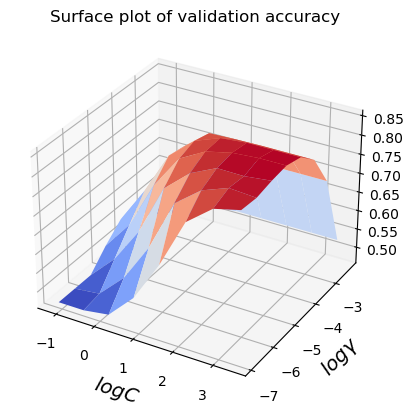

In [11]:
from matplotlib import pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(np.log(X), np.log(Y), Z, cmap="coolwarm")
ax.set_xlabel(r"$log{C}$", weight='bold', size='x-large')
ax.set_ylabel(r"$log{\gamma}$", weight='bold', size='x-large')
ax.set_title("Surface plot of validation accuracy")
plt.show()

### 任务3.2答题区(另起一行时请记得加注释符号#) ###
### BEGIN YOUR SOLUTION ###
#
### END YOUR SOLUTION ###

# SVM模型的训练、评估与解释

$\quad$最后, 我们以最优超参数配置`best_params`在全体训练集上进行模型的训练, 并对训练、测试性能作出评估.

In [12]:
best_params

{'C': 16.378937069540637, 'gamma': 0.0071968567300115215}

## 训练与评估

- **任务4**: 完成函数`train_and_eval`的编写, 输入:
  - `best_params`, 经过超参数优化后的最优配置;
  - `X_train`、`X_test`、`y_true_train`、`y_true_test`, 为训练集和测试集的对应数据.
- 返回: 三元元组, 内容分别为:
  - 训练好的模型对象`clf`;
  - 训练集上的**混淆矩阵**(confusion matrix)`cm_train`;
  - 测试集上的混淆矩阵`cm_test`.

In [13]:
from sklearn.metrics import confusion_matrix

def train_and_eval(
    best_params, X_train: np.array, X_test: np.array, y_true_train: np.array, y_true_test: np.array
) -> Tuple[object, np.array, np.array]:
    ### BEGIN YOUR SOLUTION ###
    
    clf = SVC(C=best_params["C"], gamma=best_params["gamma"])
    clf.fit(X_train, y_true_train)
    y_pred_train = clf.predict(X_train)
    y_pred_test = clf.predict(X_test)
    cm_train = confusion_matrix(y_true_train, y_pred_train)
    cm_test = confusion_matrix(y_true_test, y_pred_test)
    return (clf, cm_train, cm_test)
    ### END YOUR SOLUTION ###

$\quad$完成该函数后, 请**务必**运行下面的代码块, 完成训练与评估的过程.

In [14]:
clf, cm_train, cm_test = train_and_eval(
    best_params, X_train, X_test, y_true_train, y_true_test
)

$\quad$完成训练/评估后, 请运行下面的两个代码块, 分别对训练集、测试集上的混淆矩阵进行可视化.

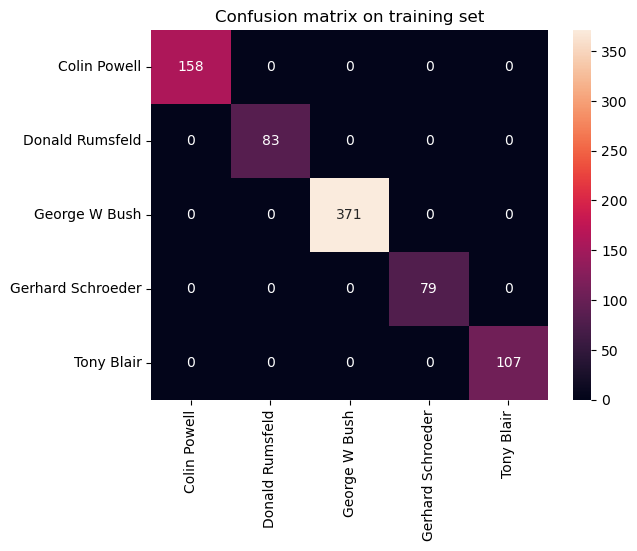

In [15]:
import pandas as pd
import seaborn as sns

cm_train = pd.DataFrame(cm_train, index=target_names, columns=target_names)
sns.heatmap(cm_train, annot=True, fmt=".0f")
plt.title("Confusion matrix on training set")
plt.show()

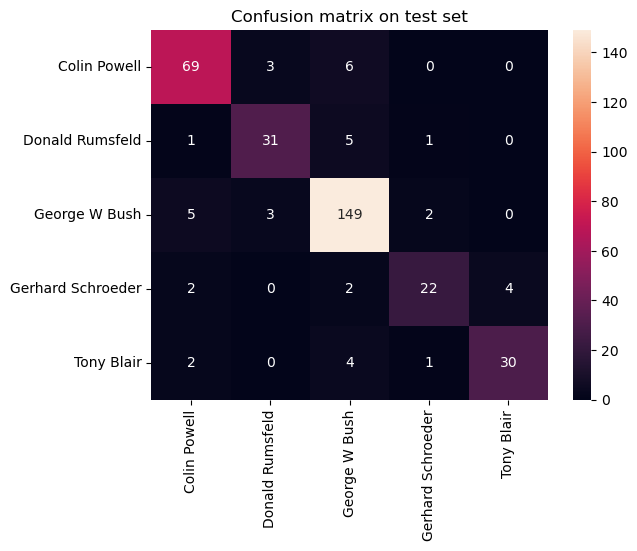

In [16]:
cm_test = pd.DataFrame(cm_test, index=target_names, columns=target_names)
sns.heatmap(cm_test, annot=True, fmt=".0f")
plt.title("Confusion matrix on test set")
plt.show()

## 支持向量(support vector)的可视化

$\quad$现在, 我们简单查看各个类别的支持向量. 它们是模型决策的依据.

- **任务5**: 完成函数`plot_support_vectors`的编写, 实现如下功能: 对每个类别, 在该类别的所有支持向量中随机抽取一个, 以[`plt.imshow`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html#matplotlib-pyplot-imshow)函数分别将其(照片)绘制出来. 输入:
  - `clf`, 训练好的分类模型;
  - `target_names`, 人名构成的列表;
  - 图片尺寸`height`、`width`;
  - 随机数种子`seed`, 用于保持随机算法的可复现性.

不返回任何内容. 一些作图要求:
- 所有人脸照片排在同一行;
- 图片标题为两行文字, 第一行: `True: <true_name>`, 第二行: `Pred: <pred_name>`. 其中, `true_name`为该样本的真实标签对应的人名, `pred_name`为该样本的预测标签对应的人名.

其余格式自选, 不作硬性要求.

### 提示
- 可以采用[`random.choice`](https://docs.python.org/3/library/random.html#random.choice)函数进行随机采样. 设置随机数种子的方法为[`random.seed`](https://docs.python.org/3/library/random.html#random.seed).
- 支持向量储存在模型对象的`support_vectors_`属性中, 已经按类别标签值由小到大排序; 每个类别的支持向量的总数储存在模型对象`n_support_`属性中, 也同样按类别标签值由小到大排序.
- 切记每个支持向量是“压扁”的图片, 需要按照尺寸参数进行`reshape`, 再绘制.

In [17]:
# _, ax = plt.subplots(figsize=(2, 2))
# data = clf.support_vectors_[0].reshape(50, 37)
# plt.imshow(data)                    
clf.predict(clf.support_vectors_[2:5])

array([0, 0, 0])

In [18]:
import random

def plot_support_vectors(clf, target_names: List[str], height: int, width: int, seed: int=42):
    ### BEGIN YOUR SOLUTION ###
    pred_all = clf.predict(clf.support_vectors_)
    seed = 1
    random.seed(seed)
    min_index = 0
    image_list = []
    pred_tile = []
    true_title = []
    for i in range(len(clf.n_support_)):
      max_index = min_index + clf.n_support_[i]
      data = [i for  i in range(min_index, max_index)]
      random_index = random.choice(data)
      image_list.append(clf.support_vectors_[random_index].reshape(height, width))
      pred_tile.append(target_names[pred_all[random_index]])
      true_title.append(target_names[i])
      min_index=max_index
    fig, axs = plt.subplots(1, len(image_list), figsize=(10,1))
    for ax, image, t_title, p_title in zip(axs, image_list, true_title, pred_tile):
      ax.set_title("".join(["True:", t_title, "\n", "Pred:", p_title]),fontdict={"fontsize":10})
      ax.imshow(image)
    ### END YOUR SOLUTION ###

$\quad$完成该函数后, 就可以运行下面的代码块查看支持向量啦🥳! 怎么样? 你的模型是不是非常不脸盲了呢?

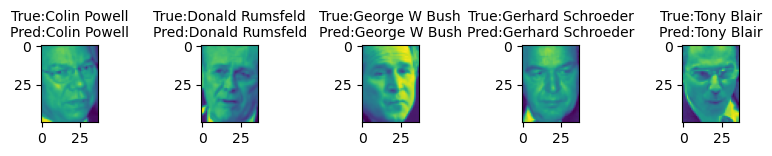

In [19]:
plot_support_vectors(clf, target_names, H, W, n_classes)